In [3]:
import re
import tensorflow as tf
import tensorflow_datasets as tfds
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, LSTM, Dropout, Dense, Activation, Bidirectional
from tensorflow.keras.models import Model

# Ensure you have the NLTK stopwords downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Set of stopwords
stop_words = set(stopwords.words('english'))

import pandas as pd  # Importing pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Importing matplotlib for plotting and visualization
import seaborn as sns  # Importing seaborn for statistical data visualization
import plotly.express as px  # Importing plotly express for interactive plots
from mafrom matplotlib import style  # Importing style from matplotlib for setting plot styles

# Import necessary libraries for ROC (Receiver Operating Characteristic) and AUC (Area Under the Curve)
from sklearn.metrics import roc_curve, auc

style.use('ggplot')  # Setting the style of plots to 'ggplot' for a clean, high-contrast look

from nltk.stem import PorterStemmer  # Importing PorterStemmer for stemming words to their root form

# Importing stopwords from NLTK (Natural Language Toolkit) library to filter out common words like 'and', 'the', etc.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))  # Initializing the set of English stopwords from NLTK

from wordcloud import WordCloud  # Importing WordCloud for generating word cloud visualizations

# Importing TfidfVectorizer for converting a collection of raw documents to a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features
from sklearn.feature_extraction.text import TfidfVectorizer

# Importing train_test_split for splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alireza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alireza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Reading the dataset from a CSV file named 'IMDB Dataset.csv' into a pandas DataFrame
df = pd.read_csv('IMDB Dataset.csv')

# Displaying the first 5 rows of the DataFrame to get an overview of the data
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Getting the shape of the DataFrame, which returns a tuple representing the dimensionality of the DataFrame
# (number of rows, number of columns)
df.shape

(50000, 2)

In [7]:
# Displaying a concise summary of the DataFrame, which includes the number of non-null entries,
# data types of each column, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


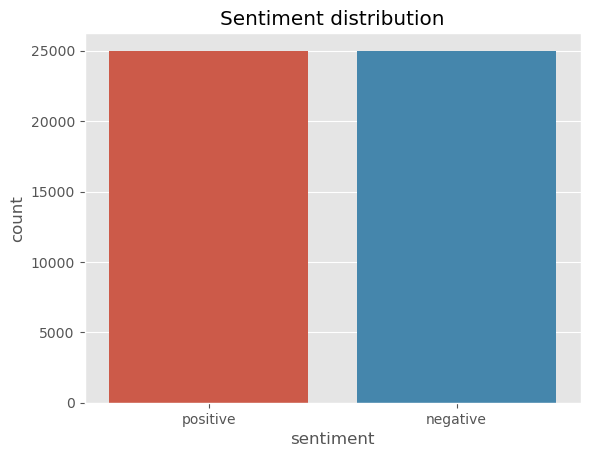

In [8]:
# Creating a count plot to visualize the distribution of the 'sentiment' column in the DataFrame
sns.countplot(x='sentiment', data=df)

# Adding a title to the plot for better understanding
plt.title("Sentiment distribution")
plt.show()

In [9]:
# Looping through the first 5 rows of the DataFrame to print each review along with its sentiment
for i in range(5):
    print("Review: ", [i])  # Printing the index of the review
    print(df['review'].iloc[i], "\n")  # Printing the review text from the 'review' column
    print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")  # Printing the sentiment associated with the review

Review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [10]:
def data_processing(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove '<br />' tags
    text = re.sub('<br />', '', text)
    
    # Remove URLs
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags=re.MULTILINE)
    
    # Remove '@' and '#' symbols
    text = re.sub(r'\@\w+|\#', '', text)
    
    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text into words
    text_tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in text_tokens if not w in stop_words]
    
    # Generate the frequency table
    freq_table = Counter(filtered_text)
    
    # Convert frequency table to a DataFrame for better readability
    freq_df = pd.DataFrame(freq_table.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    return " ".join(filtered_text), freq_df

In [11]:
# Counting the number of duplicate entries in the DataFrame
duplicated_count = df.duplicated().sum()

# Printing the number of duplicate entries
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [12]:
# Removing duplicate entries based on the 'review' column in the DataFrame
df = df.drop_duplicates('review')

In [13]:
stemmer = PorterStemmer()  # Initializing a PorterStemmer object for word stemming

def stemming(data):
    # Applying stemming to each word in the input data using the PorterStemmer
    return " ".join(stemmer.stem(word) for word in word_tokenize(data))

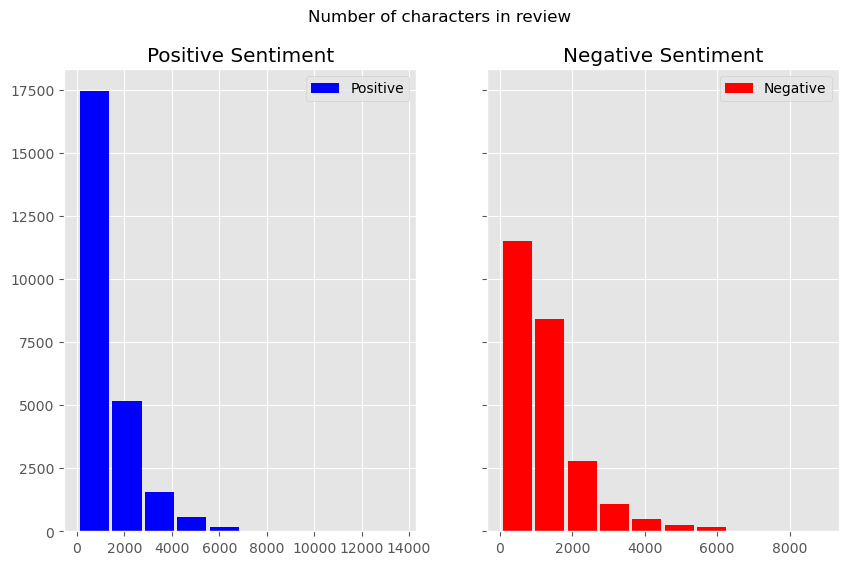

In [14]:
# Creating a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plotting a histogram of review lengths (number of characters) for 'positive' sentiment reviews in the first subplot
ax[0].hist(df[df['sentiment'] == 'positive']['review'].str.len(), label='Positive', color='blue', rwidth=0.9)
ax[0].legend(loc='upper right')  # Adding a legend to the first subplot
ax[0].set_title('Positive Sentiment')  # Adding a title to the first subplot

# Plotting a histogram of review lengths (number of characters) for 'negative' sentiment reviews in the second subplot
ax[1].hist(df[df['sentiment'] == 'negative']['review'].str.len(), label='Negative', color='red', rwidth=0.9)
ax[1].legend(loc='upper right')  # Adding a legend to the second subplot
ax[1].set_title('Negative Sentiment')  # Adding a title to the second subplot

# Adding a title to the entire figure
fig.suptitle("Number of characters in review")

plt.show()

In [15]:
# Replacing sentiment labels with numerical values for easier processing
df.sentiment.replace("positive", 1, inplace=True)  # Replace 'positive' with 1
df.sentiment.replace("negative", 2, inplace=True)  # Replace 'negative' with 2

In [16]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,2
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [17]:
# Creating a new DataFrame 'pos_reviews' containing only the rows where sentiment is 1 (positive)
pos_reviews = df[df.sentiment == 1]

# Displaying the first few rows of the 'pos_reviews' DataFrame to review positive sentiment reviews
pos_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1


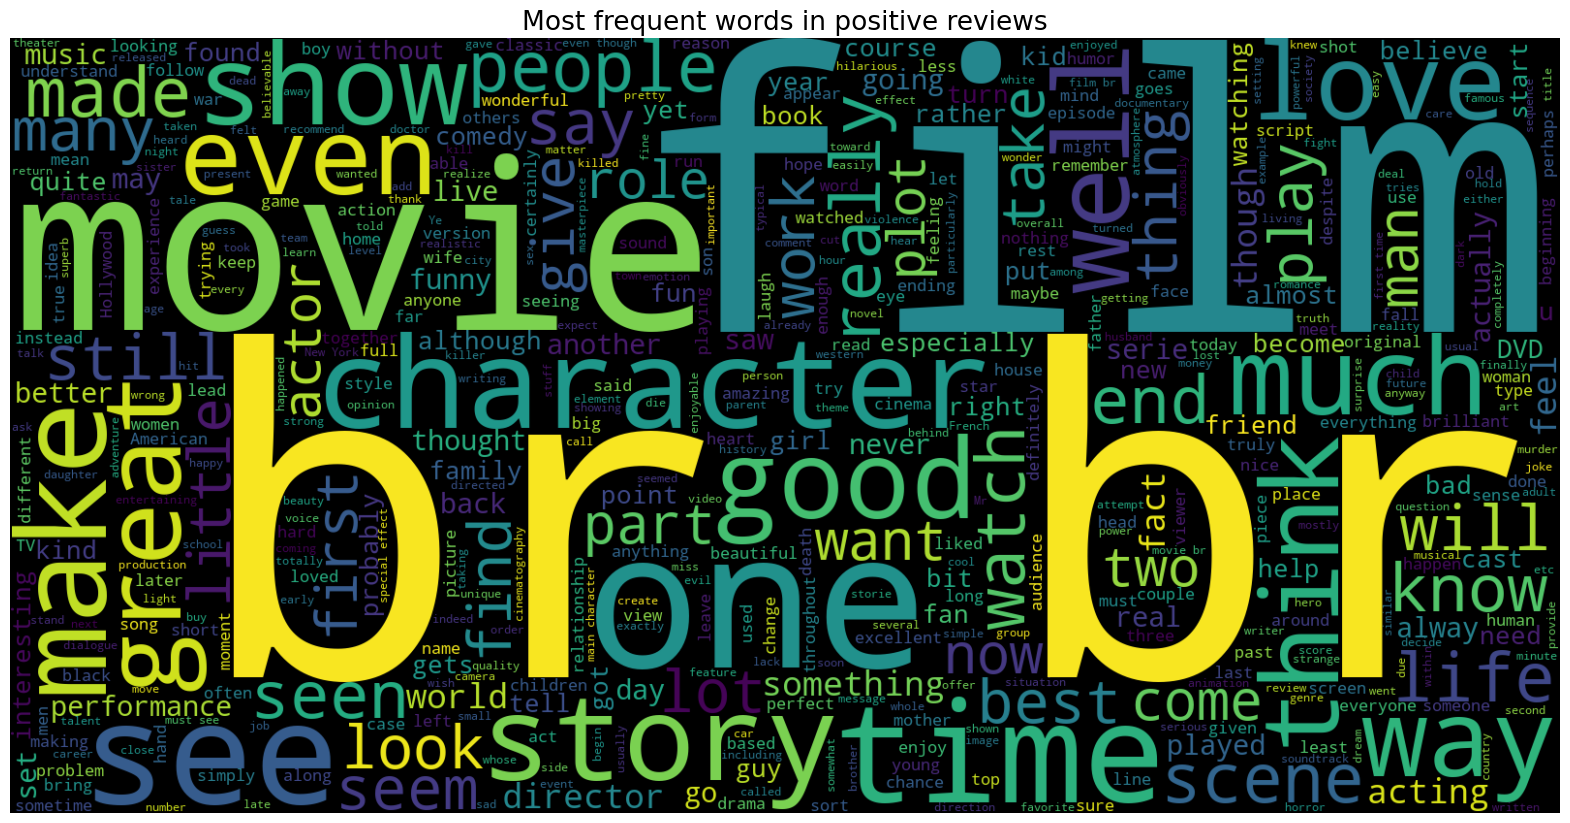

In [18]:
# Concatenating all reviews from the 'pos_reviews' DataFrame into a single string
text = ' '.join([word for word in pos_reviews['review']])

# Creating a figure for plotting the word cloud with specific size and facecolor
plt.figure(figsize=(20, 15), facecolor='None')

# Generating a word cloud from the concatenated text with specified parameters
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)

# Displaying the word cloud image with bilinear interpolation
plt.imshow(wordcloud, interpolation='bilinear')

# Removing axis labels from the plot
plt.axis('off')

# Adding a title to the plot
plt.title('Most frequent words in positive reviews', fontsize=19)

# Displaying the plot
plt.show()

In [19]:
from collections import Counter  # Importing Counter from collections module

count = Counter()  # Initializing a Counter object to count word occurrences

# Iterating through each review text in the 'review' column of 'pos_reviews'
for text in pos_reviews['review'].values:
    # Splitting each review text into words and updating the Counter with word counts
    for word in text.split():
        count[word] += 1

# Retrieving the 15 most common words and their frequencies from the Counter
most_common_words = count.most_common(15)

most_common_words

[('the', 290932),
 ('and', 165372),
 ('a', 155251),
 ('of', 148673),
 ('to', 127921),
 ('is', 107829),
 ('in', 90145),
 ('that', 62191),
 ('I', 61914),
 ('it', 53162),
 ('this', 51403),
 ('/><br', 48800),
 ('as', 46419),
 ('with', 43153),
 ('was', 41934)]

In [20]:
# Creating a DataFrame 'pos_words' from the 15 most common words and their counts
pos_words = pd.DataFrame(count.most_common(15))

# Renaming the columns of the DataFrame to 'word' and 'count'
pos_words.columns = ['word', 'count']

# Creating a bar plot using Plotly Express, where 'count' is on the x-axis and 'word' is on the y-axis
# Each bar is colored based on the word itself
fig = px.bar(pos_words, x='count', y='word', title='Common words in positive reviews', color='word')
fig.show()

In [21]:
# Creating a new DataFrame 'neg_reviews' containing only the rows where sentiment is 2 (negative)
neg_reviews = df[df.sentiment == 2]

# Displaying the first few rows of the 'neg_reviews' DataFrame to review negative sentiment reviews
neg_reviews.head()

,review,sentiment
3,Basically there's a family where a little boy ...,2
7,"This show was an amazing, fresh & innovative i...",2
8,Encouraged by the positive comments about this...,2
10,Phil the Alien is one of those quirky films wh...,2
11,I saw this movie when I was about 12 when it c...,2


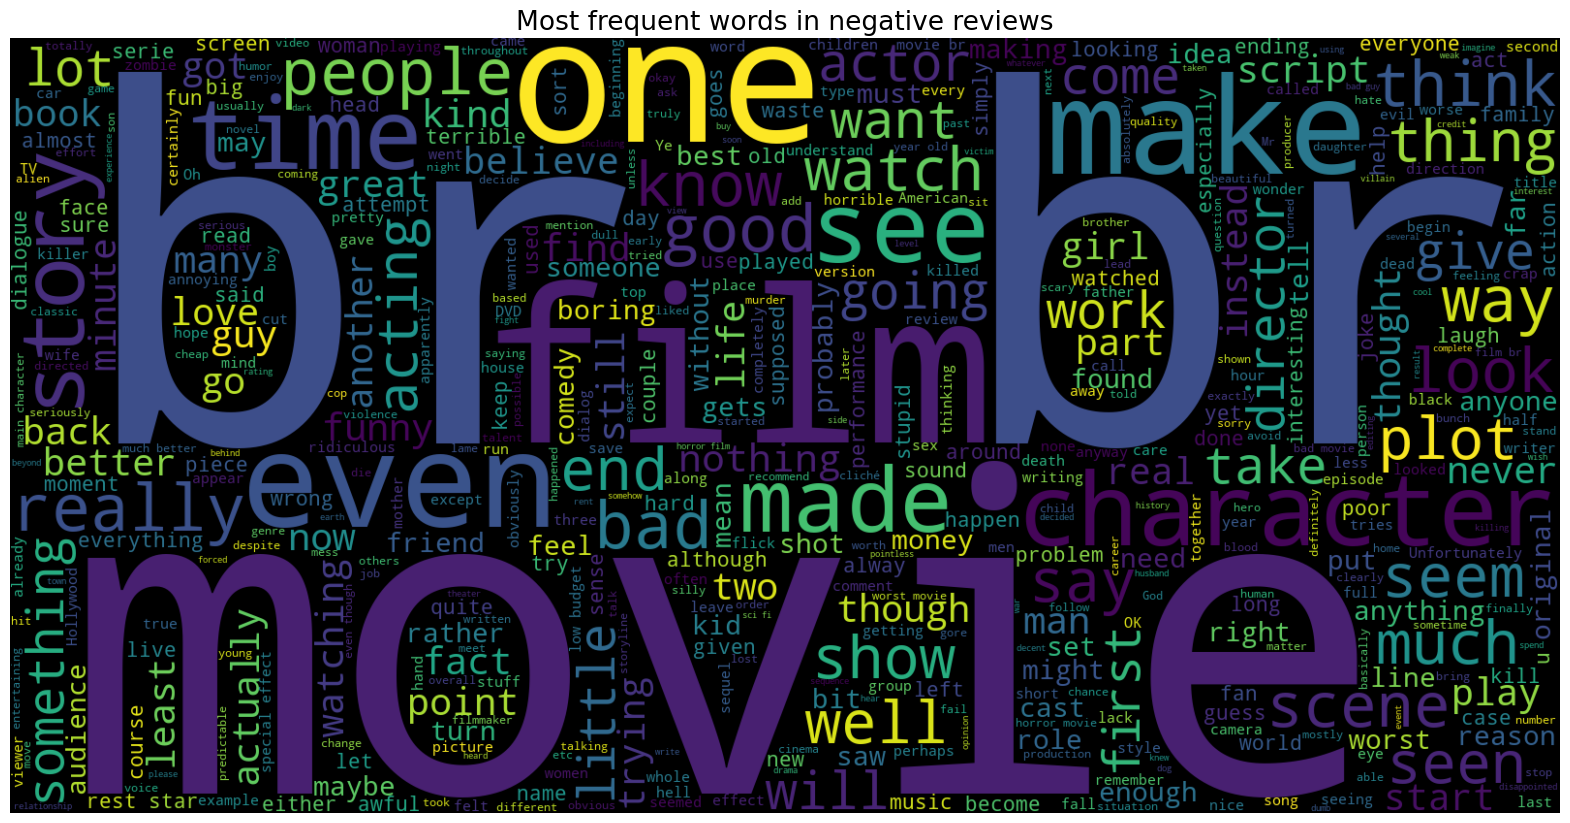

In [22]:
# Concatenating all reviews from the 'neg_reviews' DataFrame into a single string
text = ' '.join([word for word in neg_reviews['review']])

# Creating a figure for plotting the word cloud with specific size and facecolor
plt.figure(figsize=(20, 15), facecolor='None')

# Generating a word cloud from the concatenated text with specified parameters
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)

# Displaying the word cloud image with bilinear interpolation
plt.imshow(wordcloud, interpolation='bilinear')

# Removing axis labels from the plot
plt.axis('off')

# Adding a title to the plot
plt.title('Most frequent words in negative reviews', fontsize=19)

# Displaying the plot
plt.show()

In [23]:

count = Counter()  # Initializing a Counter object to count word occurrences

# Iterating through each review text in the 'review' column of 'neg_reviews'
for text in neg_reviews['review'].values:
    # Splitting each review text into words and updating the Counter with word counts
    for word in text.split():
        count[word] += 1

# Retrieving the 15 most common words and their frequencies from the Counter
most_common_words = count.most_common(15)

most_common_words

[('the', 273542),
 ('a', 149568),
 ('and', 134388),
 ('of', 132924),
 ('to', 131974),
 ('is', 93846),
 ('in', 78593),
 ('I', 69449),
 ('that', 63687),
 ('this', 61414),
 ('it', 53956),
 ('/><br', 51411),
 ('was', 49969),
 ('for', 39373),
 ('with', 38797)]

In [24]:
# Creating a DataFrame 'neg_words' from the 15 most common words and their counts in negative reviews
neg_words = pd.DataFrame(count.most_common(15))

# Renaming the columns of the DataFrame to 'word' and 'count' for clarity
neg_words.columns = ['word', 'count']

# Creating a bar plot using Plotly Express, where 'count' is on the x-axis and 'word' is on the y-axis
# Each bar is colored based on the word itself
px.bar(neg_words, x='count', y='word', title='Common words in negative reviews', color='word')
fig.show()

## Transforming data for fitting the models 

In [25]:
X = df['review']      # Assigning 'review' column as feature variable X
Y = df['sentiment']   # Assigning 'sentiment' column as target variable Y

In [26]:
vect = TfidfVectorizer()  # Initializing a TfidfVectorizer object

# Transforming the 'review' column text data into a sparse matrix of TF-IDF features
X = vect.fit_transform(df['review'])

In [27]:
# Splitting the data into training and testing sets
# X represents the features (TF-IDF vectors of reviews), Y represents the target variable (sentiments)
# test_size=0.3 specifies that 30% of the data will be used for testing, and 70% for training
# random_state=42 sets a seed for random number generation for reproducibility
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [28]:
# Printing the sizes (shapes) of the training and testing datasets
print("Size of x_train: ", x_train.shape)  # Size of training data features (TF-IDF vectors of reviews)
print("Size of y_train: ", y_train.shape)  # Size of training data target labels (sentiments)
print("Size of x_test: ", x_test.shape)    # Size of testing data features (TF-IDF vectors of reviews)
print("Size of y_test: ", y_test.shape)    # Size of testing data target labels (sentiments)

Size of x_train:  (34707, 101895)
Size of y_train:  (34707,)
Size of x_test:  (14875, 101895)
Size of y_test:  (14875,)


## Imports of the second part (model implementation)

In [29]:
from sklearn.linear_model import LogisticRegression  # Importing Logistic Regression classifier
from sklearn.naive_bayes import MultinomialNB  # Importing Multinomial Naive Bayes classifier
from sklearn.svm import LinearSVC  # Importing Linear Support Vector Classifier (SVM)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Importing metrics for evaluation
import warnings
warnings.filterwarnings('ignore')  # Ignoring warnings for cleaner output

### logistic regression implementation

In [30]:
logreg = LogisticRegression()  # Initializing Logistic Regression model
logreg.fit(x_train, y_train)  # Training the model using training data
logreg_pred = logreg.predict(x_test)  # Making predictions on the test data
logreg_acc = accuracy_score(logreg_pred, y_test)  # Calculating accuracy score

# Printing the test accuracy of the Logistic Regression model
print("Test accuracy: {:.2f}%".format(logreg_acc * 100))

Test accuracy: 89.60%


In [31]:
# Printing the confusion matrix for the Logistic Regression model
print(confusion_matrix(y_test, logreg_pred))
print("\n")  # Adding a newline for better readability
# Printing the classification report for the Logistic Regression model
print(classification_report(y_test, logreg_pred))

[[6771  700]
 [ 847 6557]]


              precision    recall  f1-score   support

           1       0.89      0.91      0.90      7471
           2       0.90      0.89      0.89      7404

    accuracy                           0.90     14875
   macro avg       0.90      0.90      0.90     14875
weighted avg       0.90      0.90      0.90     14875



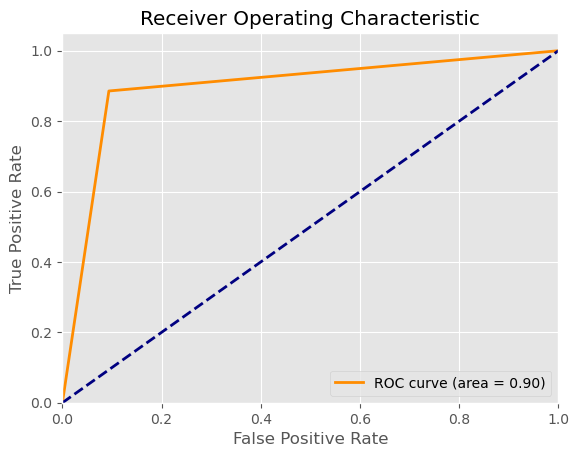

In [32]:
# Adjust labels from {1, 2} to {0, 1}
# This is often necessary when dealing with binary classification problems where the classifier expects labels in a {0, 1} format.
y_test_adjusted = (y_test == 2).astype(int)  # Convert labels 2 to 1, and labels 1 to 0

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_adjusted, logreg_pred)

# Calculate the Area Under the Curve (AUC) for the ROC curve
roc_auc = auc(fpr, tpr)

# Create a new figure for plotting the ROC curve
plt.figure()

# Plot the ROC curve with FPR on the x-axis and TPR on the y-axis
# 'darkorange' is used for the curve color, 'lw=2' sets the line width, and the label shows the AUC value
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot a diagonal dashed line to represent the 'no-skill' classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the limits of the x-axis from 0.0 to 1.0
plt.xlim([0.0, 1.0])

# Set the limits of the y-axis from 0.0 to 1.05 to ensure the curve fits nicely within the plot
plt.ylim([0.0, 1.05])

# Label the x-axis as 'False Positive Rate'
plt.xlabel('False Positive Rate')

# Label the y-axis as 'True Positive Rate'
plt.ylabel('True Positive Rate')

# Set the title of the plot to 'Receiver Operating Characteristic'
plt.title('Receiver Operating Characteristic')

# Display a legend in the lower right corner of the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

### multinomial naive bayes implementation

In [33]:
mnb = MultinomialNB()            # Initializing Multinomial Naive Bayes model
mnb.fit(x_train, y_train)        # Training the model using training data
mnb_pred = mnb.predict(x_test)   # Making predictions on the test data
mnb_acc = accuracy_score(mnb_pred, y_test)  # Calculating accuracy score

# Printing the test accuracy of the Multinomial Naive Bayes model
print("Test accuracy: {:.2f}%".format(mnb_acc * 100))

Test accuracy: 86.11%


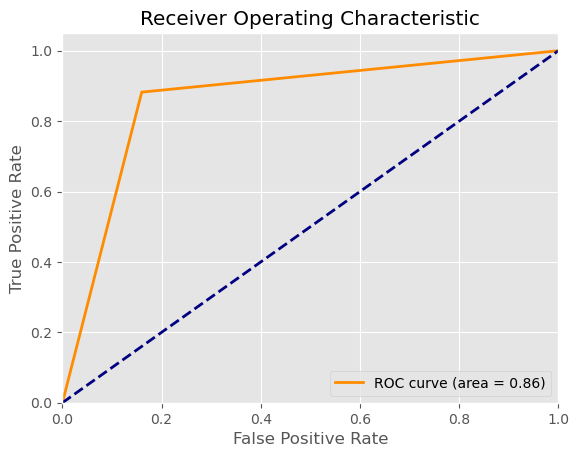

In [34]:
# Adjust labels from {1, 2} to {0, 1}
# This adjustment is required for binary classification where labels are expected to be {0, 1}.
y_test_adjusted = (y_test == 2).astype(int)  # Convert labels: change 2 to 1, and 1 to 0

# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
# mnb_pred contains the predicted probabilities from a Multinomial Naive Bayes classifier
fpr, tpr, thresholds = roc_curve(y_test_adjusted, mnb_pred)

# Calculate the Area Under the Curve (AUC) for the ROC curve
roc_auc = auc(fpr, tpr)

# Create a new figure for the ROC curve plot
plt.figure()

# Plot the ROC curve: FPR on x-axis, TPR on y-axis
# 'darkorange' is used for the curve color, 'lw=2' sets the line width, and the label includes the AUC value
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot a diagonal dashed line to represent a 'no-skill' classifier (random guessing)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the limits of the x-axis from 0.0 to 1.0
plt.xlim([0.0, 1.0])

# Set the limits of the y-axis from 0.0 to 1.05 to ensure the curve is fully visible
plt.ylim([0.0, 1.05])

# Label the x-axis as 'False Positive Rate'
plt.xlabel('False Positive Rate')

# Label the y-axis as 'True Positive Rate'
plt.ylabel('True Positive Rate')

# Set the title of the plot to 'Receiver Operating Characteristic'
plt.title('Receiver Operating Characteristic')

# Display a legend in the lower right corner of the plot
plt.legend(loc="lower right")

# Show the plot
plt.show()

In [45]:
# Printing the confusion matrix for the Multinomial Naive Bayes model
print(confusion_matrix(y_test, mnb_pred))
print("\n")  # Adding a newline for better readability
# Printing the classification report for the Multinomial Naive Bayes model
print(classification_report(y_test, mnb_pred))

[[6276 1195]
 [ 871 6533]]


              precision    recall  f1-score   support

           1       0.88      0.84      0.86      7471
           2       0.85      0.88      0.86      7404

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



### support vector machine implementation

In [46]:
svc = LinearSVC()                # Initializing Linear Support Vector Classifier (SVM)
svc.fit(x_train, y_train)        # Training the model using training data
svc_pred = svc.predict(x_test)   # Making predictions on the test data
svc_acc = accuracy_score(svc_pred, y_test)  # Calculating accuracy score

# Printing the test accuracy of the Linear SVM model
print("Test accuracy: {:.2f}%".format(svc_acc * 100))

Test accuracy: 89.90%


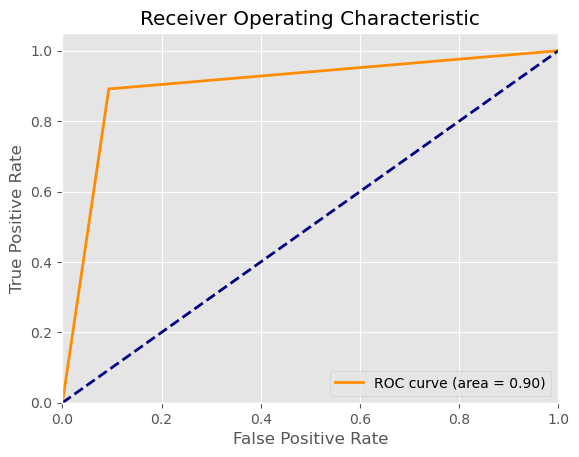

In [47]:
# Adjust labels from {1, 2} to {0, 1}
# This adjustment ensures the labels are suitable for binary classification (0 and 1).
y_test_adjusted = (y_test == 2).astype(int)  # Convert labels: change 2 to 1, and 1 to 0

# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
# svc_pred contains the predicted probabilities from a Support Vector Classifier (SVC)
fpr, tpr, thresholds = roc_curve(y_test_adjusted, svc_pred)

# Calculate the Area Under the Curve (AUC) for the ROC curve
roc_auc = auc(fpr, tpr)

# Create a new figure for the ROC curve plot
plt.figure()

# Plot the ROC curve: FPR on x-axis, TPR on y-axis
# 'darkorange' is used for the curve color, 'lw=2' sets the line width, and the label includes the AUC value
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot a diagonal dashed line to represent a 'no-skill' classifier (random guessing)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set the limits of the x-axis from 0.0 to 1.0
plt.xlim([0.0, 1.0])

# Set the limits of the y-axis from 0.0 to 1.05 to ensure the curve is fully visible
plt.ylim([0.0, 1.05])

# Label the x-axis as 'False Positive Rate'
plt.xlabel('False Positive Rate')

# Label the y-axis as 'True Positive Rate'
plt.ylabel('True Positive Rate')

# Set the title of the plot to 'Receiver Operating Characteristic'
plt.title('Receiver Operating Characteristic')

# Display a legend in the lower right corner of the plot
plt.legend(loc="lower right")

# Show the plot
plt.show()

In [48]:
# Printing the confusion matrix for the Linear SVM model
print(confusion_matrix(y_test, svc_pred))
print("\n")  # Adding a newline for better readability
# Printing the classification report for the Linear SVM model
print(classification_report(y_test, svc_pred))

[[6772  699]
 [ 804 6600]]


              precision    recall  f1-score   support

           1       0.89      0.91      0.90      7471
           2       0.90      0.89      0.90      7404

    accuracy                           0.90     14875
   macro avg       0.90      0.90      0.90     14875
weighted avg       0.90      0.90      0.90     14875



In [2]:
# Preprocessing function
def data_processing(text):
    text = text.numpy().decode('utf-8')  # Decode from bytes to string
    text = text.lower()  # Convert text to lowercase
    text = re.sub('<br />', '', text)  # Remove '<br />' tags
    text = re.sub(r'https\S+|www\S+|http\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove '@' and '#' symbols
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation marks
    text_tokens = word_tokenize(text)  # Tokenize the text into words
    filtered_text = [w for w in text_tokens if not w in stop_words]  # Remove stopwords
    return " ".join(filtered_text)  # Join the filtered words back into a single string

def tf_data_processing(text, label):
    # This function applies data processing to a given text tensor within a TensorFlow pipeline.
    # `tf.py_function` allows the use of a Python function `data_processing` within a TensorFlow graph.
    # `data_processing` is a custom function that processes the text data.
    # The processed text is then returned along with the original label.
    
    # Apply the custom data processing function to the text tensor.
    # `data_processing` should be a function that takes a text input and returns processed text.
    # `tf.py_function` is used to wrap the Python function so it can be used within a TensorFlow graph.
    text = tf.py_function(data_processing, [text], tf.string)
    
    # Return the processed text and the original label.
    return text, label



In [13]:
# Load the IMDB dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Apply preprocessing to the dataset
train_dataset = train_dataset.map(tf_data_processing)
test_dataset = test_dataset.map(tf_data_processing)

# Collect all texts from the training dataset
train_texts = [text.decode('utf-8') for text, label in tfds.as_numpy(train_dataset)]
test_texts = [text.decode('utf-8') for text, label in tfds.as_numpy(test_dataset)]


# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Find the maximum sequence length
max_sequence_length = max(len(seq) for seq in train_sequences)

print("Maximum sequence length:", max_sequence_length)

# Padding sequences to the maximum length for both train and test sets
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# Example output
print("Tokenized and padded sequences (train):", train_padded_sequences[:5])
print("Tokenized and padded sequences (test):", test_padded_sequences[:5])

# Converting the sequences back to a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded_sequences, [label for text, label in tfds.as_numpy(train_dataset)]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_padded_sequences, [label for text, label in tfds.as_numpy(test_dataset)]))

# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Maximum sequence length: 1429
Tokenized and padded sequences (train): [[  303   278     1 ...     0     0     0]
 [  494   655  2202 ...     0     0     0]
 [ 4650  6085 27807 ...     0     0     0]
 [  138     2  8382 ...     0     0     0]
 [  268   911   256 ...     0     0     0]]
Tokenized and padded sequences (test): [[   23    24  3970 ...     0     0     0]
 [39877   600   664 ...     0     0     0]
 [  509     1  2475 ...     0     0     0]
 [  227  4259 13720 ...     0     0     0]
 [  982 58059  1350 ...     0     0     0]]


### The LSTM Model implementation

In [4]:
def load_word2vec(file_path):
    # Initialize an empty dictionary to store the word to vector mappings
    word_to_vec_map = {}
    
    # Open the word2vec file in binary read mode
    with open(file_path, 'rb') as f:
        # Read the header line which contains the vocabulary size and vector size
        header = f.readline()
        vocab_size, vector_size = map(int, header.split())
        
        # Calculate the length of each vector in bytes
        binary_len = np.dtype('float32').itemsize * vector_size
        
        # Iterate over each word in the vocabulary
        for _ in range(vocab_size):
            word = []
            
            # Read characters to build the word until a space is encountered
            while True:
                ch = f.read(1)
                if ch == b' ':
                    break
                if ch != b'\n':
                    word.append(ch)
            
            # Join the list of characters to form the word and decode from bytes to string
            word = b''.join(word).decode('utf-8')
            
            # Read the corresponding vector from the file and convert it from bytes to a numpy array
            vector = np.frombuffer(f.read(binary_len), dtype='float32')
            
            # Add the word and its vector to the dictionary
            word_to_vec_map[word] = vector
    
    # Sort the words alphabetically to ensure consistent indexing
    words = sorted(word_to_vec_map.keys())
    
    # Create a mapping from words to their index positions, starting from 1
    words_to_index = {w: i + 1 for i, w in enumerate(words)}
    
    # Create a mapping from index positions to words
    index_to_words = {i + 1: w for i, w in enumerate(words)}
    
    # Return the two mappings and the word to vector map
    return words_to_index, index_to_words, word_to_vec_map

In [5]:
# Define function to create the embedding layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    # Determine the vocabulary size (number of words)
    vocab_size = len(word_to_vec_map) + 1  # +1 to account for the reserved index 0
    
    # Get embedding dimensions by checking the dimension of the vector for any word
    random_word = next(iter(word_to_vec_map))
    emb_dim = word_to_vec_map[random_word].shape[0]

    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros((vocab_size, emb_dim))

    # Populate the embedding matrix with the vectors from word_to_vec_map
    for word, idx in word_to_index.items():
        embedding_matrix[idx, :] = word_to_vec_map[word]

    # Create the embedding layer using Keras
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)  # trainable=False makes the layer non-trainable
    
    # Build the embedding layer to initialize it
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([embedding_matrix])
    
    # Return the embedding layer
    return embedding_layer

In [6]:
# Define the LSTM model
def create_model(input_shape, word_to_vec_map, word_to_index):
    # Input layer that takes indices of words in sentences
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer using pre-trained word vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Apply the embedding layer to the input sentence indices
    embeddings = embedding_layer(sentence_indices)
    
    # Add a bidirectional LSTM layer with 128 units that returns sequences (for stacking LSTM layers)
    X = Bidirectional(LSTM(units=128, return_sequences=True))(embeddings)
    
    # Add a dropout layer to prevent overfitting (dropout rate of 0.5)
    X = Dropout(0.5)(X)
    
    # Add another bidirectional LSTM layer with 128 units that does not return sequences (for the final output)
    X = Bidirectional(LSTM(units=128, return_sequences=False))(X)
    
    # Add another dropout layer to prevent overfitting (dropout rate of 0.5)
    X = Dropout(0.5)(X)
    
    # Add a dense layer with a single unit
    X = Dense(1)(X)
    
    # Apply a sigmoid activation function to the output (for binary classification)
    X = Activation('sigmoid')(X)
    
    # Create the model with the input sentence indices and the output layer
    model = Model(inputs=sentence_indices, outputs=X)
    
    # Return the constructed model
    return model

In [7]:
def sentence_to_indices(X, vocab_size, word_to_vec_map):
    m = X.shape[0]  # Number of examples in X
    
    X_ind = np.zeros((m, vocab_size))  # Initialize index matrix with zeros
    
    for i in range(m):
        words = X[i].lower().split()  # Split the lowercased sentence into words
        for j, word in enumerate(words):
            if word in word_to_vec_map:
                X_ind[i, j] = word_to_vec_map[word]  # Assign the index of the word from word_to_vec_map
    
    return X_ind

In [8]:
# Path to the Google News vectors binary file
file_path = 'GoogleNews-vectors-negative300.bin'

# Load the Word2Vec embeddings and mappings
word_to_index, index_to_word, word_to_vec_map = load_word2vec(file_path)

In [14]:
# Create a model using the create_model function
model = create_model(max_sequence_length, word_to_vec_map, word_to_index)

In [15]:
# Compile the model with specified optimizer, loss function, and metrics
model.compile(optimizer='adam',           # Use the Adam optimizer, which is commonly used in deep learning tasks
              loss='binary_crossentropy',  # Use binary cross-entropy as the loss function for binary classification
              metrics=['accuracy'])        # Track accuracy metric during training and evaluation

In [16]:
# Train the model using the fit method
history = model.fit(train_dataset,           # Training dataset (features and labels)
                    epochs=10,               # Number of training epochs (iterations over the entire dataset)
                    validation_data=test_dataset)  # Validation dataset for evaluating performance during training

Epoch 1/10
782/782 [==============================] - 15663s 20s/step - loss: 0.6728 - accuracy: 0.5688 - val_loss: 0.6705 - val_accuracy: 0.5764
Epoch 2/10
782/782 [==============================] - 12730s 16s/step - loss: 0.6066 - accuracy: 0.6681 - val_loss: 0.6006 - val_accuracy: 0.6627
Epoch 3/10
782/782 [==============================] - 11337s 15s/step - loss: 0.5572 - accuracy: 0.7176 - val_loss: 0.5230 - val_accuracy: 0.7377
Epoch 4/10
782/782 [==============================] - 14018s 18s/step - loss: 0.5521 - accuracy: 0.7185 - val_loss: 0.5088 - val_accuracy: 0.7487
Epoch 5/10
782/782 [==============================] - 13329s 17s/step - loss: 0.5138 - accuracy: 0.7495 - val_loss: 0.5622 - val_accuracy: 0.7070
Epoch 6/10
782/782 [==============================] - 12413s 16s/step - loss: 0.5010 - accuracy: 0.7584 - val_loss: 0.4950 - val_accuracy: 0.7646
Epoch 7/10
782/782 [==============================] - 13130s 17s/step - loss: 0.4816 - accuracy: 0.7745 - val_loss: 0.5117 -

In [38]:
# Save the trained model to an HDF5 file
model.save("my_model.h5")

In [18]:
# Evaluate the model by predicting probabilities and converting them to binary predictions
y_pred_prob = model.predict(test_dataset)  # Predict probabilities for test_dataset
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Convert test_dataset to numpy arrays for generating confusion matrix and classification report
test_data, test_labels = [], []
for x, y in test_dataset:
    test_data.append(x.numpy())  # Convert TensorFlow tensors to NumPy arrays
    test_labels.append(y.numpy())  # Convert TensorFlow tensors to NumPy arrays
test_data = np.concatenate(test_data)  # Combine all data arrays into a single NumPy array
test_labels = np.concatenate(test_labels)  # Combine all label arrays into a single NumPy array

782/782 [==============================] - 1987s 3s/step


In [35]:
from sklearn.metrics import accuracy_score, f1_score  # Importing accuracy and F1 score metrics from sklearn
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
from sklearn.metrics import auc, roc_curve, confusion_matrix, precision_score, recall_score  # Importing various metrics from sklearn

In [42]:
from sklearn.metrics import classification_report  # Importing classification report from sklearn.metrics

In [43]:
accuracy_score(test_labels, y_pred),  # Calculate accuracy score
f1_score(test_labels, y_pred),         # Calculate F1 score
precision_score(test_labels, y_pred),  # Calculate precision score
recall_score(test_labels, y_pred)      # Calculate recall score

(0.78292, 0.7653595053828527, 0.8327217988521968, 0.70808)

In [44]:

# Generate confusion matrix using test_labels (actual) and y_pred (predicted)
cm = confusion_matrix(test_labels, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10722  1778]
 [ 3649  8851]]


In [45]:
# Generate ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [47]:
# Generate classification report (includes precision, recall, F1-score)
print("Classification Report:")
print(classification_report(test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80     12500
           1       0.83      0.71      0.77     12500

    accuracy                           0.78     25000
   macro avg       0.79      0.78      0.78     25000
weighted avg       0.79      0.78      0.78     25000



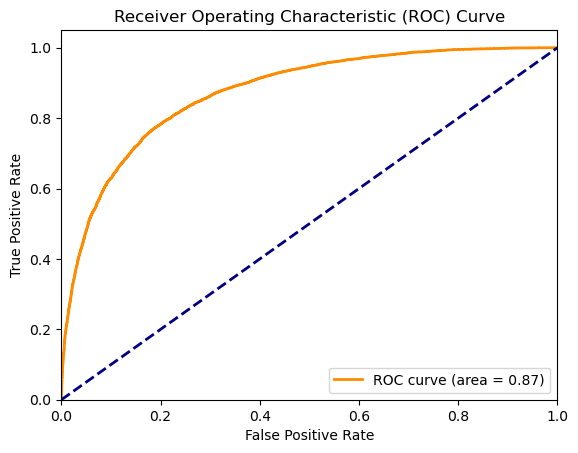

In [48]:
# Plot ROC curve
plt.figure()  # Create a new figure for the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot ROC curve with AUC score
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot diagonal line (random classifier)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')   # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title of the plot
plt.legend(loc='lower right')  # Display legend in lower right corner
plt.show()  # Display the plot

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 147ms/step - loss: 0.6475 - accuracy: 0.5609 - val_loss: 0.4901 - val_accuracy: 0.7437
Epoch 2/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3915 - accuracy: 0.8246 - val_loss: 0.3549 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3391 - accuracy: 0.8532 - val_loss: 0.3771 - val_accuracy: 0.8000
Epoch 4/10
391/391 [==============================] - 45s 113ms/step - loss: 0.3200 - accuracy: 0.8630 - val_loss: 0.3283 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3120 - accuracy: 0.8660 - val_loss: 0.3491 - val_accuracy: 0.8453
Epoch 6/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3105 - accuracy: 0.8664 - val_loss: 0.3209 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3049 - accuracy: 0.8685 - val_loss: 0.3149 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 47ms/step - loss: 0.3226 - accuracy: 0.8623
Test Loss: 0.32261183857917786
Test Accuracy: 0.8623200058937073


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.9146806]]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was exemplary!. The animation and the graphics were awesome.. I will highly recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 32ms/step
[[1.8050212]]


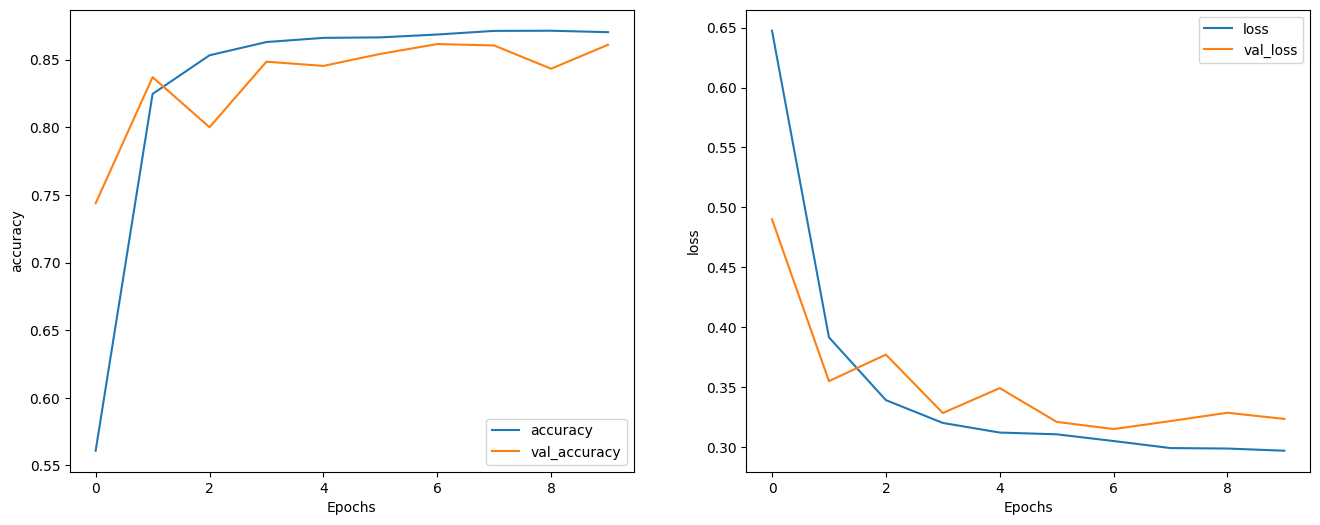

In [ ]:
plt.figure(figsize=(16, 6))  # Create a figure with a specific size (width: 16 inches, height: 6 inches)

# Subplot 1: Plot accuracy
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, subplot 1)
plot_graphs(history, 'accuracy')  # Call plot_graphs function to plot accuracy

# Subplot 2: Plot loss
plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, subplot 2)
plot_graphs(history, 'loss')  # Call plot_graphs function to plot loss

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()  # Display the plot

In [49]:
from sklearn.ensemble import VotingClassifier

vtc = VotingClassifier(
    estimators=[('lr', logreg), ('svc', svc)],
    voting='hard'  # Use 'hard' voting, for 'soft' voting, estimators must support predict_proba
)

vtc.fit(x_train, y_train)        # Training the model using training data
vtc_pred = vtc.predict(x_test)   # Making predictions on the test data
vtc_acc = accuracy_score(vtc_pred, y_test)  # Calculating accuracy score

# Printing the test accuracy of the Linear SVM model
print("Test accuracy: {:.2f}%".format(vtc_acc * 100))

Test accuracy: 89.59%


In [50]:
# Printing the confusion matrix for the Linear SVM model
print(confusion_matrix(y_test, svc_pred))
print("\n")  # Adding a newline for better readability
# Printing the classification report for the Linear SVM model
print(classification_report(y_test, svc_pred))

[[6772  699]
 [ 804 6600]]


              precision    recall  f1-score   support

           1       0.89      0.91      0.90      7471
           2       0.90      0.89      0.90      7404

    accuracy                           0.90     14875
   macro avg       0.90      0.90      0.90     14875
weighted avg       0.90      0.90      0.90     14875

